# IMPORTS

In [ ]:
SEED = 42

import numpy as np
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from torchvision.transforms.functional import to_pil_image

# !pip install torchview
# !pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

import random

import os
import torch
torch.manual_seed(SEED)
from torch import nn
from torchvision import models
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
import torch.nn.functional as F
import torch.optim as optim
import gc
from tqdm import tqdm
from scipy import ndimage as ndi



if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
gc.collect()
torch.cuda.empty_cache()



SRC_FOLDER = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_data"              
SRC_TEST_FOLDER = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/test_data"              
SRC_TRAIN_LABELS = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_labels.csv"

DST_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_preprocessed_images"   
DST_CONTEXT_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_context_images"    
 
DST_TEST_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_preprocessed_images"
DST_TEST_CONTEXT_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_context_images" 

DST_LABELS = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_preprocessed_labels.csv" 
DST_REMOVED_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_removed_images" 

DST_TILE_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_images"
DST_TILE_LABELS = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_labels.csv"
TEST_TILE_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_test_images"
DST_TEST_TILE_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_test_images"
DST_TILE_CORRESPONDANCE = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_tile_correspondance.csv"

for dir_path in [DST_FOLDER, DST_TEST_FOLDER, DST_REMOVED_FOLDER, DST_CONTEXT_FOLDER, DST_TEST_CONTEXT_FOLDER, DST_TILE_FOLDER, DST_TEST_TILE_FOLDER]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)  # Nuke the entire folder
        
    os.makedirs(dir_path, exist_ok=True)  # Recreate it



PyTorch version: 2.5.1+cu121
Device: cuda


In [ ]:
def get_ids_from_folder(folder):
    ids = set()
    for f in os.listdir(folder):
        if f.startswith("img_") or f.startswith("mask_"):
            name, ext = os.path.splitext(f)
            if name.startswith("img_"):
                ids.add(name.replace("img_", ""))
            elif name.startswith("mask_"):
                ids.add(name.replace("mask_", ""))
    def sort_key(x):
        try:
            return int(x)
        except ValueError:
            return x
    return sorted(ids, key=sort_key)

def crop_square_tumor_region(image, mask):
    """
    image: (H,W,3) float32 [0,1]
    mask:  (H,W,1) float32 [0,1] or 0/255
    Returns the squared region with minimum area containing the tumor.
    """
    mask_bin = (mask.squeeze() > 0).astype(np.uint8)

    if mask_bin.sum() == 0:
        return image, mask

    ys, xs = np.where(mask_bin == 1)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    h = y_max - y_min + 1
    w = x_max - x_min + 1
    side = max(h, w)

    cy = (y_min + y_max) // 2
    cx = (x_min + x_max) // 2

    y1 = cy - side // 2
    y2 = y1 + side
    x1 = cx - side // 2
    x2 = x1 + side

    H, W = mask_bin.shape
    if y1 < 0:
        y2 += -y1
        y1 = 0
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y2 > H:
        y1 -= (y2 - H)
        y2 = H
    if x2 > W:
        x1 -= (x2 - W)
        x2 = W

    y1 = max(0, y1)
    x1 = max(0, x1)

    img_crop  = image[y1:y2, x1:x2]
    mask_crop = mask[y1:y2, x1:x2]

    return img_crop, mask_crop

def check_green_blob(img, g_thr=0.7, diff_thr=0.2, min_ratio=0.001):
    R, G, B = img[..., 0], img[..., 1], img[..., 2]
    green_mask = (G > g_thr) & ((G - R) > diff_thr) & ((G - B) > diff_thr)
    green_ratio = green_mask.mean()
    has_green = green_ratio > min_ratio
    return has_green, green_ratio

def scan_green_blobs(src_folder, ids,
                     g_thr=0.7, diff_thr=0.2, min_ratio=0.001,
                     max_plot=12):
    """
    Runs through all images and detects green artifacts
    and plots some examples. Also returns suspicious IDs
    """
    suspeitas = []      # (id, img, green_ratio)
    suspected_ids = []

    for i, base_id in enumerate(ids):
        img_path = os.path.join(src_folder, f"img_{base_id}.png")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[WARNING] could not read {img_path}, skipping green-scan.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        has_green, green_ratio = check_green_blob(img, g_thr, diff_thr, min_ratio)
        if has_green:
            suspected_ids.append(base_id)
            # store only a few examples for plotting
            if len(suspeitas) < max_plot:
                suspeitas.append((base_id, img, green_ratio))

    if len(suspected_ids) == 0:
        print("No images with green peak detected.")
        return []

    print(f"{len(suspected_ids)} images with green blobs.")
    print("Some detected IDs:", suspected_ids[:20])

    # Plot some examples
    cols = 4
    rows = int(np.ceil(len(suspeitas) / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for j, (bid, img, green_ratio) in enumerate(suspeitas):
        plt.subplot(rows, cols, j + 1)
        plt.imshow(img)
        plt.title(f"ID={bid}\nGreen={green_ratio:.4f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return suspected_ids

def plot_score_outliers_from_disk(src_folder, df_out, score_name, max_images=20):
    if len(df_out) == 0:
        print(f"No outlier images for {score_name}.")
        return

    df_plot = df_out.head(max_images)

    n = len(df_plot)
    cols = 5
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(4*cols, 4*rows))

    for i, row in enumerate(df_plot.itertuples()):
        img_path = os.path.join(src_folder, f"img_{row.id}.png")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        z_val = getattr(row, score_name + "_z")

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"id={row.id}\nz={z_val:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# **VERSION OF PRE-PROCESSMENT**

In [64]:
VERSION = "v1"

## **TRAIN_DATA**

### **Images**

In [ ]:
def get_ids_from_folder(folder):
    ids = set()
    for f in os.listdir(folder):
        if f.startswith("img_") or f.startswith("mask_"):
            name, ext = os.path.splitext(f)
            if name.startswith("img_"):
                ids.add(name.replace("img_", ""))
            elif name.startswith("mask_"):
                ids.add(name.replace("mask_", ""))
    def sort_key(x):
        try: return int(x)
        except: return x
    return sorted(ids, key=sort_key)

ids = get_ids_from_folder(SRC_FOLDER)
print("IDs found (raw):", ids[:10])


IDs encontrados (raw): ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']


#### **Crop**

In [66]:
def crop_square_tumor_region(image, mask):
    mask_bin = (mask.squeeze() > 0).astype(np.uint8)

    if mask_bin.sum() == 0:
        return image, mask

    ys, xs = np.where(mask_bin == 1)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    h = y_max - y_min + 1
    w = x_max - x_min + 1
    side = max(h, w)

    cy = (y_min + y_max) // 2
    cx = (x_min + x_max) // 2

    y1 = cy - side // 2
    y2 = y1 + side
    x1 = cx - side // 2
    x2 = x1 + side

    H, W = mask_bin.shape
    if y1 < 0:
        y2 += -y1
        y1 = 0
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y2 > H:
        y1 -= (y2 - H)
        y2 = H
    if x2 > W:
        x1 -= (x2 - W)
        x2 = W

    y1 = max(0, y1)
    x1 = max(0, x1)

    img_crop  = image[y1:y2, x1:x2]
    mask_crop = mask[y1:y2, x1:x2]

    return img_crop, mask_crop


#### **Blob**

50 imagens com artefato verde.
IDs: ['0001', '0012', '0018', '0020', '0028', '0044', '0047', '0052', '0078', '0090', '0094', '0130', '0150', '0161', '0175', '0184', '0222', '0268', '0293', '0333']


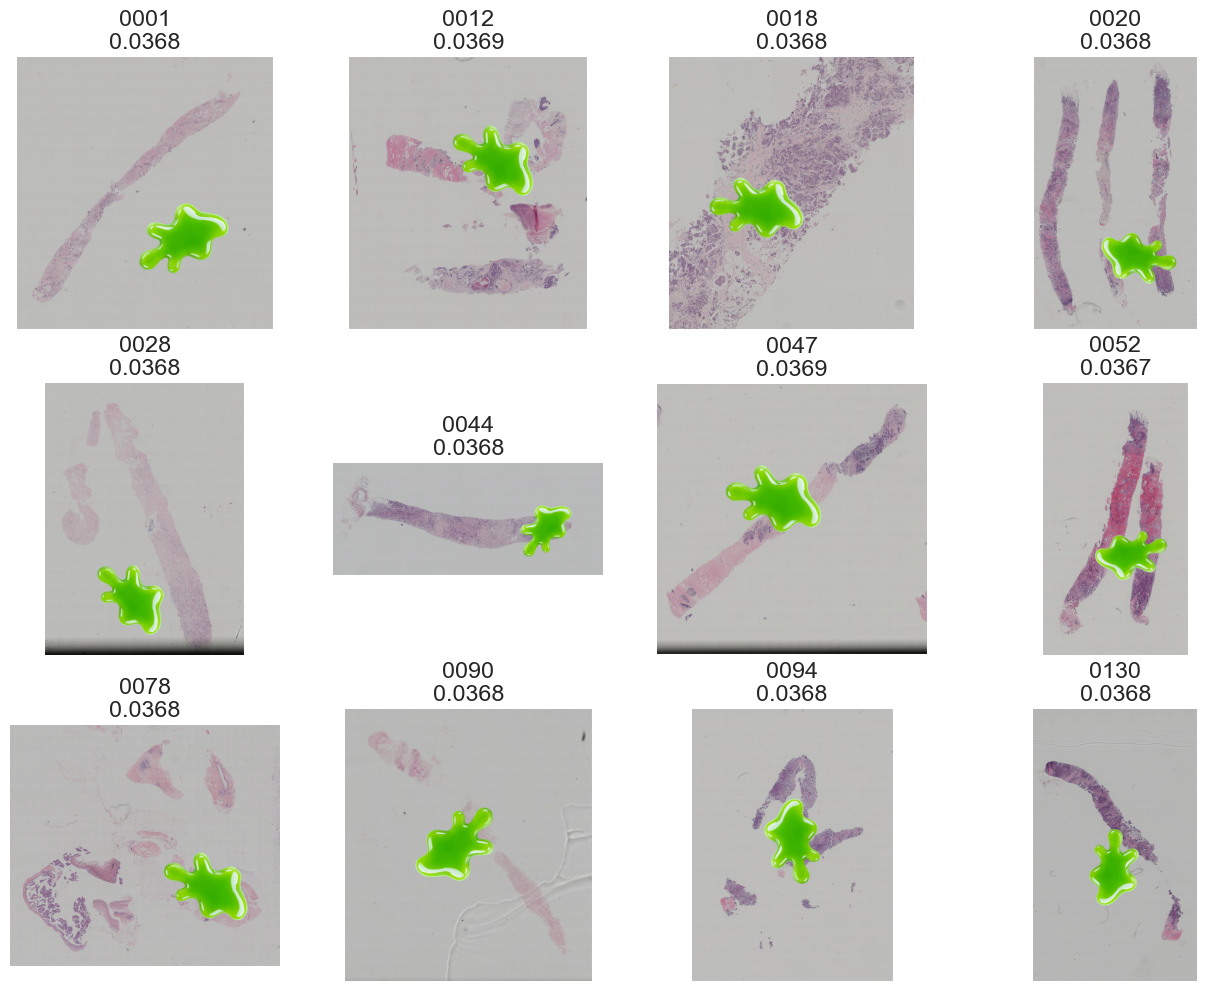

In [ ]:
def check_green_blob(img, g_thr=0.7, diff_thr=0.2, min_ratio=0.001):
    R, G, B = img[..., 0], img[..., 1], img[..., 2]
    green_mask = (G > g_thr) & ((G - R) > diff_thr) & ((G - B) > diff_thr)
    green_ratio = green_mask.mean()
    return green_ratio > min_ratio, green_ratio

def scan_green_blobs(src_folder, ids, max_plot=12):
    suspeitas = []
    suspected_ids = []

    for base_id in ids:
        img_path = os.path.join(src_folder, f"img_{base_id}.png")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        has_green, green_ratio = check_green_blob(img)
        if has_green:
            suspected_ids.append(base_id)
            if len(suspeitas) < max_plot:
                suspeitas.append((base_id, img, green_ratio))

    print(f"{len(suspected_ids)} images with green artifact.")
    print("IDs:", suspected_ids[:20])

    # plot examples
    if suspeitas:
        cols = 4
        rows = int(np.ceil(len(suspeitas) / cols))
        plt.figure(figsize=(4*cols, 4*rows))
        for j,(bid,img,gr) in enumerate(suspeitas):
            plt.subplot(rows, cols, j+1)
            plt.imshow(img)
            plt.title(f"{bid}\n{gr:.4f}")
            plt.axis("off")
        plt.show()

    return suspected_ids

green_blob_ids = scan_green_blobs(SRC_FOLDER, ids)


#### **Shreks**

In [68]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil

# -------------------------
# Compute color stats (use mask)
# -------------------------
def compute_color_stats_from_disk(src_folder, ids):
    rows = []
    for idx, base_id in enumerate(ids):
        img_path  = os.path.join(src_folder, f"img_{base_id}.png")
        mask_path = os.path.join(src_folder, f"mask_{base_id}.png")

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(mask_path) else None

        if img is None:
            # skip missing images (or raise if you prefer)
            print(f"Warning: image missing for ID={base_id}, skipping.")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        if mask is not None:
            mask = (mask.astype(np.float32) / 255.0)
            mask_bin = mask > 0.5
            if mask_bin.sum() > 0:
                pixels = img[mask_bin]
            else:
                # fallback to full image if mask empty
                pixels = img.reshape(-1, 3)
        else:
            # no mask available => use full image
            pixels = img.reshape(-1, 3)

        means = pixels.mean(axis=0)  # R, G, B
        sums  = pixels.sum(axis=1).mean()  # approximate brightness mean

        rows.append({
            "id": base_id,
            "idx": idx,
            "R_mean": means[0],
            "G_mean": means[1],
            "B_mean": means[2],
            "brightness": means.sum(),   # R+G+B average in [0,3]
            "pixel_count": pixels.shape[0]
        })

    return pd.DataFrame(rows)

# -------------------------
# Add per-metric detectors (ratios + diffs)
# -------------------------
def add_color_metrics(df):
    eps = 1e-6

    # difference-style scores (like you used before)
    df["green_score"] = df["G_mean"] - 0.5*(df["R_mean"] + df["B_mean"])
    df["red_score"]   = df["R_mean"] - 0.5*(df["G_mean"] + df["B_mean"])
    df["blue_score"]  = df["B_mean"] - 0.5*(df["R_mean"] + df["G_mean"])

    # dominance ratios (good for dark cases)
    df["green_ratio"] = df["G_mean"] / (df["R_mean"] + df["B_mean"] + eps)
    df["brown_ratio"] = (df["R_mean"] + df["G_mean"]) / (df["B_mean"] + eps)  # brownish = R+G >> B
    df["red_ratio"]   = df["R_mean"] / (df["G_mean"] + df["B_mean"] + eps)

    # an explicit brown-ish diff-score (balanced version)
    df["brown_score"] = 0.7*(df["R_mean"] + df["G_mean"]) - df["B_mean"]

    # darkness (lower brightness means darker)
    # Keep as brightness (higher = brighter), but detect dark by low brightness.
    df["brightness"] = df["brightness"]  # range 0..3 in normalized image

    # optionally scale/normalize metrics if you will use absolute thresholds
    return df

# -------------------------
# Generic detector: per-metric
# - mode: "zscore" or "absolute"
# - for zscore we return rows with z > z_thr
# - for absolute we return rows with metric > abs_thr (or < abs_thr if invert=True)
# -------------------------
def detect_outliers_for_metric(df, metric_name, mode="zscore", z_thr=2.0, abs_thr=None, invert=False, verbose=False):
    """
    invert=False -> detects metric > abs_thr
    invert=True  -> detects metric < abs_thr (useful for brightness -> detect dark)
    """
    if mode == "zscore":
        vals = df[metric_name].values
        mu = vals.mean()
        sigma = vals.std() + 1e-8
        z = (vals - mu) / sigma
        df[metric_name + "_z"] = z
        df_out = df[z > z_thr].copy()
        if verbose:
            print(f"[zscore] {metric_name}: {len(df_out)} (z>{z_thr})")
        return df_out

    elif mode == "absolute":
        if abs_thr is None:
            raise ValueError("abs_thr required for absolute mode")
        if invert:
            df_out = df[df[metric_name] < abs_thr].copy()
            if verbose:
                print(f"[abs] {metric_name}: {len(df_out)} ( < {abs_thr})")
        else:
            df_out = df[df[metric_name] > abs_thr].copy()
            if verbose:
                print(f"[abs] {metric_name}: {len(df_out)} ( > {abs_thr})")
        return df_out
    else:
        raise ValueError("mode must be 'zscore' or 'absolute'")

# -------------------------
# Iterative pipeline: detect per metric and remove union (OR)
# copies removed and kept images to folders
# -------------------------
def iterative_color_outlier_detection_per_metric(
    src_folder,
    ids,
    metrics_config,
    max_iters=3,
    verbose=True
):
    """
    metrics_config: dict where keys are metric names (must exist in df after add_color_metrics)
    and values are dict with:
      - mode: "zscore" or "absolute"
      - z_thr: (for zscore)
      - abs_thr: (for absolute)
      - invert: (for absolute; boolean)
      - save_flag: whether to copy removed images for this metric (optional)
    Example:
    metrics_config = {
        "green_ratio": {"mode":"absolute", "abs_thr": 1.5, "invert":False},
        "brown_ratio": {"mode":"absolute", "abs_thr": 2.0, "invert":False},
        "brightness": {"mode":"absolute", "abs_thr": 0.6, "invert":True},  # remove dark: brightness < 0.6
        "green_score": {"mode":"zscore", "z_thr": 2.0},
    }
    """
    current_ids = ids.copy()
    removed_total = set()
    detection_log = []  # list of (id, metric) pairs explaining removals

    for it in range(1, max_iters+1):
        if verbose:
            print(f"\n=== Iteration {it}/{max_iters} ===")
            print(f"Input IDs: {len(current_ids)}")

        df = compute_color_stats_from_disk(src_folder, current_ids)
        df = add_color_metrics(df)

        # accumulate outlier ids this iteration (union)
        out_ids_this_iter = set()
        out_details = {}  # id -> list of metric triggers

        for metric, cfg in metrics_config.items():
            mode = cfg.get("mode", "zscore")
            z_thr = cfg.get("z_thr", 2.0)
            abs_thr = cfg.get("abs_thr", None)
            invert = cfg.get("invert", False)
            verbose_metric = cfg.get("verbose", False)

            try:
                out_df = detect_outliers_for_metric(df, metric, mode=mode, z_thr=z_thr, abs_thr=abs_thr, invert=invert, verbose=verbose_metric)
                print(f"Metric {metric}: detected {len(out_df)} outliers on iteration {it}.")
            except Exception as e:
                print(f"Skipping metric {metric} due to error: {e}")
                continue

            for rid in out_df["id"].values:
                out_ids_this_iter.add(rid)
                out_details.setdefault(rid, []).append(metric)

        if verbose:
            print(f"Outliers detected this iter: {len(out_ids_this_iter)} (union across metrics)")

        if len(out_ids_this_iter) == 0:
            if verbose:
                print("No new outliers found — stopping early.")
            break

        # copy removed images to removed folder (one folder for all removed this run)
        for oid in out_ids_this_iter:
            detection_log.append((oid, out_details.get(oid, [])))

        removed_total.update(out_ids_this_iter)
        current_ids = [i for i in current_ids if i not in out_ids_this_iter]

    # finally copy kept images to kept folder

    # return kept, removed, and a DataFrame log for inspection
    log_df = pd.DataFrame([{"id": i, "metrics": m} for (i, m) in detection_log])
    return current_ids, removed_total, log_df

# -------------------------
# Example config and usage
# -------------------------

metrics_config = {
    # detect green dominance even when dark -> absolute ratio threshold
    "green_ratio": {"mode":"absolute", "abs_thr": 0.8, "invert":False, "verbose": False},

    # detect brown/green-brown (R+G >> B)
    "brown_ratio": {"mode":"absolute", "abs_thr": 3.7, "invert":False, "verbose": False},

    # detect explicitly low brightness -> "dark" images (invert True)
    # brightness is R+G+B average in 0..3. A value like 0.6 means average channel ~0.2 (dark).
    "brightness": {"mode":"absolute", "abs_thr": 0.7, "invert":True, "verbose": False},

    # keep zscore-based detector for difference-style green_score to catch extreme cases
    "green_score": {"mode":"zscore", "z_thr": 2.7, "verbose": False},

    # optional: red indicators
    "red_score": {"mode":"zscore", "z_thr": 5.0, "verbose": False},
    "red_ratio": {"mode":"absolute", "abs_thr": 0.9, "invert": False, "verbose": False},
}

kept_ids, removed_ids, log_df = iterative_color_outlier_detection_per_metric(
    src_folder=SRC_FOLDER,
    ids=ids,
    metrics_config=metrics_config,
    max_iters=3,
    verbose=True
)

print("\nKept:", len(kept_ids))
print("Removed:", len(removed_ids))
print("Log head:\n", log_df.head())



=== Iteration 1/3 ===
Input IDs: 691
Metric green_ratio: detected 46 outliers on iteration 1.
Metric brown_ratio: detected 99 outliers on iteration 1.
Metric brightness: detected 30 outliers on iteration 1.
Metric green_score: detected 43 outliers on iteration 1.
Metric red_score: detected 3 outliers on iteration 1.
Metric red_ratio: detected 30 outliers on iteration 1.
Outliers detected this iter: 104 (union across metrics)

=== Iteration 2/3 ===
Input IDs: 587
Metric green_ratio: detected 0 outliers on iteration 2.
Metric brown_ratio: detected 0 outliers on iteration 2.
Metric brightness: detected 0 outliers on iteration 2.
Metric green_score: detected 6 outliers on iteration 2.
Metric red_score: detected 2 outliers on iteration 2.
Metric red_ratio: detected 0 outliers on iteration 2.
Outliers detected this iter: 8 (union across metrics)

=== Iteration 3/3 ===
Input IDs: 579
Metric green_ratio: detected 0 outliers on iteration 3.
Metric brown_ratio: detected 0 outliers on iteration 

In [ ]:
# ---------------------------
# 1) Find the actual length of the IDs
# ---------------------------
id_len = max(len(str(x)) for x in ids)

def pad_id(x):
    """Standardize ID to have the same number of digits."""
    return str(x).zfill(id_len)

# ---------------------------
# 2) Standardize all IDs
# ---------------------------
ids = [pad_id(i) for i in ids]

green_blob_ids = [pad_id(i) for i in green_blob_ids]
bad_ids_color  = [pad_id(i) for i in removed_ids]

# ---------------------------
# 3) Create the final set of removals
# ---------------------------
ids_to_drop = set(green_blob_ids) | set(bad_ids_color)

print(f"🛠 Total to remove: {len(ids_to_drop)}")
print("Examples removed:", list(ids_to_drop)[:20])

# ---------------------------
# 4) Filter good IDs
# ---------------------------
kept_ids = [i for i in ids if i not in ids_to_drop]
removed_ids_all = [i for i in ids if i in ids_to_drop]

print("\n📌 Summary:")
print("  Original total :", len(ids))
print("  Total removed  :", len(ids_to_drop))
print("  Total kept     :", len(kept_ids))


🛠 Total a remover: 113
Exemplos removidos: ['0410', '0136', '0407', '0159', '0036', '0656', '0319', '0675', '0547', '0670', '0376', '0189', '0130', '0333', '0486', '0044', '0578', '0020', '0008', '0635']

📌 Resumo:
  Total originais : 691
  Total removidos : 113
  Total mantidos  : 578


### Process and Save Images

##### Tiled Images

In [ ]:
def generate_tiles(tile_size, stride, threshold, img, mask):
    tiles = []
    masks = []
    h, w, _ = img.shape
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y_end = min(h, y+tile_size)
            y_start = max(0, y_end-tile_size)
            x_end = min(x, x+tile_size)
            x_start = max(0, x_end-tile_size)

            tile_img = img[y_start:y_end, x_start:x_end] #(H, W, C)
            tile_mask = mask[y_start:y_end, x_start:x_end]
            relevance_ratio = np.sum(tile_mask) / (tile_size*tile_size)

            if ((y_end-y_start)!=tile_size) or ((x_end-x_start)!=tile_size):
                pass
            elif relevance_ratio >= threshold:
                tiles.append(tile_img)
                masks.append(tile_mask)
    return tiles, masks



def tiled_preprocess_and_save(
    src_folder,
    dst_folder,
    kept_ids,
    tile_size=224,
    stride=128,
    threshold = 0.3,
    verbose=100,
    progress_every=50,
    blur_edges=False,
):

    os.makedirs(dst_folder, exist_ok=True)

    total = len(kept_ids)
    print(f"🔧 Pre-processing {total} IDs from {src_folder} to {dst_folder} "
          f"(tile_size={tile_size})")
    
    tile_correspondance = []

    current_tile_id = 0

    for i, base_id in enumerate(kept_ids, start=1):

        img_path  = os.path.join(src_folder, f"img_{base_id}.png")
        mask_path = os.path.join(src_folder, f"mask_{base_id}.png")

        if not (os.path.exists(img_path) and os.path.exists(mask_path)):
            print(f"[WARNING] Skipping ID {base_id}: img or mask missing.")
            continue

        # --- load image ---
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[ERROR] Could not read {img_path}, skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # --- load mask ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[ERROR] Could not read {mask_path}, skipping.")
            continue
        mask = mask.astype(np.float32)
        if mask.max() > 1:
            mask = mask / 255.0
        mask = mask[..., np.newaxis]

        if i%verbose==0:
            print(f"\nID {base_id}")
            print("  Original img shape :", img.shape)
            print("  Original mask shape:", mask.shape)

        # --- CROP tumor region ---
        img_crop, mask_crop = crop_square_tumor_region(img, mask)

        # Binary mask (H, W, 1) → (H, W)
        mask_bin = (mask_crop.squeeze() > 0.5).astype(np.float32)

        # Apply mask:
        # where mask=1 keep original image, where mask=0 keep zeros
        mask_3ch = mask_bin[..., None]  # for broadcast (H, W, 1)
        img_crop = img_crop * mask_3ch # + background * (1 - mask_3ch) # add background mean color if needed


        tile_list, tile_mask_list = generate_tiles(tile_size=tile_size, stride=stride, threshold=threshold,
                           img=img_crop, mask=mask_bin)
        
        for tile, tile_mask in zip(tile_list,tile_mask_list):
            tile_correspondance.append({'sample_index': f"img_{base_id}.png", "tile_index":f"img_{pad_id(current_tile_id)}.png"})

            if i%verbose==0:
                print("  Shape after tiling images :", tile.shape)
                print(f"  Current tile id: ", current_tile_id)

            ###################################################################################################
            if blur_edges:
                blur_kernel =(21,21) # let cv2 decide
                sigma_blur = 6
                blur_bg = cv2.GaussianBlur(tile, blur_kernel, sigma_blur)
                tile = tile + blur_bg * (1 - tile_mask[..., None])
            ###################################################################################################

            # --- save tile ---
            img_uint8 = (tile * 255.0).clip(0, 255).astype(np.uint8)
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

            out_img_path  = os.path.join(dst_folder, f"img_{pad_id(current_tile_id)}.png")
            cv2.imwrite(out_img_path, img_uint8)

            current_tile_id += 1
     

        if (progress_every is not None) and (i % progress_every == 0):
            print(f"{i}/{total} IDs processed...")
            print(f"  Number of extracted tiles on last image {i}:", len(tile_list))
        

    print("\n✅ Pre-processing completed!")
    print("Pre-processed images saved in:", dst_folder)
    return tile_correspondance

tile_correspondance = tiled_preprocess_and_save(
    src_folder=SRC_FOLDER,
    dst_folder= DST_TILE_FOLDER,
    kept_ids=kept_ids,
    tile_size=224,
    verbose=200,
    threshold=0.15,
    stride=128
)

tile_df = pd.DataFrame(tile_correspondance)


🔧 Pré-processando 578 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_images (tile_size=224)
50/578 IDs processados...
  Number of extracted tiles on last image 50: 0
100/578 IDs processados...
  Number of extracted tiles on last image 100: 0
150/578 IDs processados...
  Number of extracted tiles on last image 150: 8

ID 0241
  Shape original img : (1743, 1024, 3)
  Shape original mask: (1743, 1024, 1)
  Shape after tiling images : (224, 224, 3)
  Current tile id:  483
  Shape after tiling images : (224, 224, 3)
  Current tile id:  484
  Shape after tiling images : (224, 224, 3)
  Current tile id:  485
  Shape after tiling images : (224, 224, 3)
  Current tile id:  486
  Shape after tiling images : (224, 224, 3)
  Current tile id:  487
  Shape after tiling images : (224, 224, 3)
  Current tile id:  488
  Shape after tiling images : (224, 224, 3)
  Current tile id:  489
  Shape after tili

##### Masked images

In [ ]:
def preprocess_and_save(
    src_folder,
    dst_folder,
    kept_ids,
    target_size=256,
    verbose_first=5,
    progress_every=50
):
    """
    Pre-process images + masks applying:
      - load original image and mask
      - square crop based on tumor region (crop_square_tumor_region)
      - optional resize to (target_size, target_size)
      - save in dst_folder as img_{id}.png and mask_{id}.png

    Parameters
    ----------
    src_folder : str
        Folder with the original files (img_*.png, mask_*.png)
    dst_folder : str
        Output folder to save pre-processed files.
    kept_ids : list[str]
        List of IDs (e.g., ["0001", "0002", ...]) to process.
        For each ID, expects img_{ID}.png and mask_{ID}.png.
    target_size : int or None
        If int, resizes to (target_size, target_size).
        If None, keeps crop size.
    verbose_first : int
        Number of first examples to show shapes in console.
    progress_every : int
        Interval to show progress.
    """

    os.makedirs(dst_folder, exist_ok=True)

    total = len(kept_ids)
    print(f"🔧 Pre-processing {total} IDs from {src_folder} to {dst_folder} "
          f"(target_size={target_size})")

    for i, base_id in enumerate(kept_ids, start=1):

        img_path  = os.path.join(src_folder, f"img_{base_id}.png")
        mask_path = os.path.join(src_folder, f"mask_{base_id}.png")

        if not (os.path.exists(img_path) and os.path.exists(mask_path)):
            print(f"[WARNING] Skipping ID {base_id}: img or mask missing.")
            continue

        # --- load image ---
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[ERROR] Could not read {img_path}, skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # --- load mask ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[ERROR] Could not read {mask_path}, skipping.")
            continue
        mask = mask.astype(np.float32)
        if mask.max() > 1:
            mask = mask / 255.0
        mask = mask[..., np.newaxis]

        if i <= verbose_first:
            print(f"\nID {base_id}")
            print("  Original img shape :", img.shape)
            print("  Original mask shape:", mask.shape)

        # --- CROP tumor region ---
        img_crop, mask_crop = crop_square_tumor_region(img, mask)

        # Binary mask (H, W, 1) → (H, W)
        mask_bin = (mask_crop.squeeze() > 0.5).astype(np.float32)

        # Apply mask:
        # where mask=1 keep original image, where mask=0 keep zeros
        mask_3ch = mask_bin[..., None]  # for broadcast (H, W, 1)
        img_crop = img_crop * mask_3ch # + background * (1 - mask_3ch) # add background mean color if needed

        if i <= verbose_first:
            print("  Shape after crop img :", img_crop.shape)
            print("  Shape after crop mask:", mask_crop.shape)

        # --- Optional resize ---
        if target_size is not None:
            img_crop = cv2.resize(
                img_crop,
                (target_size, target_size),
                interpolation=cv2.INTER_LINEAR
            )
            mask_crop = cv2.resize(
                mask_crop,
                (target_size, target_size),
                interpolation=cv2.INTER_NEAREST
            )
            mask_crop = mask_crop[..., np.newaxis]

            if i <= verbose_first:
                print("  Shape after resize img :", img_crop.shape)
                print("  Shape after resize mask:", mask_crop.shape)

        # --- save ---
        img_uint8 = (img_crop * 255.0).clip(0, 255).astype(np.uint8)
        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

        mask_uint8 = (mask_crop.squeeze() * 255.0).clip(0, 255).astype(np.uint8)

        out_img_path  = os.path.join(dst_folder, f"img_{base_id}.png")
        out_mask_path = os.path.join(dst_folder, f"mask_{base_id}.png")

        cv2.imwrite(out_img_path, img_uint8)
        cv2.imwrite(out_mask_path, mask_uint8)

        if (progress_every is not None) and (i % progress_every == 0):
            print(f"{i}/{total} IDs processed...")

    print("\n✅ Pre-processing completed!")
    print("Pre-processed images saved in:", dst_folder)

preprocess_and_save(
    src_folder=SRC_FOLDER,
    dst_folder= DST_FOLDER,
    kept_ids=kept_ids,
    target_size=256
)


🔧 Pré-processando 578 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_preprocessed_images (target_size=256)

ID 0000
  Shape original img : (1024, 1236, 3)
  Shape original mask: (1024, 1236, 1)
  Shape após crop img : (701, 701, 3)
  Shape após crop mask: (701, 701, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0002
  Shape original img : (1655, 1024, 3)
  Shape original mask: (1655, 1024, 1)
  Shape após crop img : (1075, 1024, 3)
  Shape após crop mask: (1075, 1024, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0003
  Shape original img : (1178, 1024, 3)
  Shape original mask: (1178, 1024, 1)
  Shape após crop img : (291, 291, 3)
  Shape após crop mask: (291, 291, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0004
  Shape original img : (1043, 1024, 3)
  Shape original

##### Context Image

In [ ]:
def context_preprocess_and_save(
    src_folder,
    dst_folder,
    kept_ids,
    target_size=256,
    verbose_first=5,
    progress_every=50
):
    """
    Parameters
    ----------
    src_folder : str
        Folder with the original files (img_*.png, mask_*.png)
    dst_folder : str
        Output folder to save pre-processed files.
    kept_ids : list[str]
        List of IDs (e.g., ["0001", "0002", ...]) to process.
        For each ID, expects img_{ID}.png and mask_{ID}.png.
    target_size : int or None
        If int, resizes to (target_size, target_size).
        If None, keeps crop size.
    verbose_first : int
        Number of first examples to show shapes in console.
    progress_every : int
        Interval to show progress.
    """

    os.makedirs(dst_folder, exist_ok=True)

    total = len(kept_ids)
    print(f"🔧 Pre-processing {total} IDs from {src_folder} to {dst_folder} "
          f"(target_size={target_size})")

    for i, base_id in enumerate(kept_ids, start=1):

        img_path  = os.path.join(src_folder, f"img_{base_id}.png")
        mask_path = os.path.join(src_folder, f"mask_{base_id}.png")

        if not (os.path.exists(img_path) and os.path.exists(mask_path)):
            print(f"[WARNING] Skipping ID {base_id}: img or mask missing.")
            continue

        # --- load image ---
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[ERROR] Could not read {img_path}, skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # --- load mask ---
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"[ERROR] Could not read {mask_path}, skipping.")
            continue
        mask = mask.astype(np.float32)
        if mask.max() > 1:
            mask = mask / 255.0
        mask = mask[..., np.newaxis]

        if i <= verbose_first:
            print(f"\nID {base_id}")
            print("  Original img shape :", img.shape)
            print("  Original mask shape:", mask.shape)

        # --- CROP tumor region ---
        img_crop, mask_crop = crop_square_tumor_region(img, mask)

        if i <= verbose_first:
            print("  Shape after crop img :", img_crop.shape)

        # --- Optional resize ---
        if target_size is not None:
            img_crop = cv2.resize(
                img_crop,
                (target_size, target_size),
                interpolation=cv2.INTER_LINEAR
            )

            if i <= verbose_first:
                print("  Shape after resize img :", img_crop.shape)

        # --- save ---
        img_uint8 = (img_crop * 255.0).clip(0, 255).astype(np.uint8)
        img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

        out_img_path  = os.path.join(dst_folder, f"img_{base_id}.png")

        cv2.imwrite(out_img_path, img_uint8)

        if (progress_every is not None) and (i % progress_every == 0):
            print(f"{i}/{total} IDs processed...")

    print("\n✅ Pre-processing completed!")
    print("Pre-processed images saved in:", dst_folder)

context_preprocess_and_save(
    src_folder=SRC_FOLDER,
    dst_folder= DST_CONTEXT_FOLDER,
    kept_ids=kept_ids,
    target_size=256
)


🔧 Pré-processando 578 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_context_images (target_size=256)

ID 0000
  Shape original img : (1024, 1236, 3)
  Shape original mask: (1024, 1236, 1)
  Shape após crop img : (701, 701, 3)
  Shape após resize img : (256, 256, 3)

ID 0002
  Shape original img : (1655, 1024, 3)
  Shape original mask: (1655, 1024, 1)
  Shape após crop img : (1075, 1024, 3)
  Shape após resize img : (256, 256, 3)

ID 0003
  Shape original img : (1178, 1024, 3)
  Shape original mask: (1178, 1024, 1)
  Shape após crop img : (291, 291, 3)
  Shape após resize img : (256, 256, 3)

ID 0004
  Shape original img : (1043, 1024, 3)
  Shape original mask: (1043, 1024, 1)
  Shape após crop img : (394, 394, 3)
  Shape após resize img : (256, 256, 3)

ID 0006
  Shape original img : (1934, 1024, 3)
  Shape original mask: (1934, 1024, 1)
  Shape após crop img : (1224, 1024, 3)
  Shape após 

#### Removed images

In [ ]:
print(len(removed_ids_all), "Removed images will be saved in", DST_REMOVED_FOLDER)

context_preprocess_and_save(
    src_folder=SRC_FOLDER,
    dst_folder= DST_REMOVED_FOLDER,
    kept_ids=removed_ids_all,
    target_size=256
)

113 imagens removidas serão salvas em: C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_removed_images
🔧 Pré-processando 113 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/train_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_removed_images (target_size=256)

ID 0001
  Shape original img : (1088, 1024, 3)
  Shape original mask: (1088, 1024, 1)
  Shape após crop img : (793, 793, 3)
  Shape após resize img : (256, 256, 3)

ID 0005
  Shape original img : (1024, 1371, 3)
  Shape original mask: (1024, 1371, 1)
  Shape após crop img : (427, 427, 3)
  Shape após resize img : (256, 256, 3)

ID 0008
  Shape original img : (1024, 1628, 3)
  Shape original mask: (1024, 1628, 1)
  Shape após crop img : (911, 911, 3)
  Shape após resize img : (256, 256, 3)

ID 0012
  Shape original img : (1171, 1024, 3)
  Shape original mask: (1171, 1024, 1)
  Shape após crop img : (829, 829, 3)
  Shape após resize img : (256, 256, 3)

ID 0018
  Shape ori

## **Labels Alignment**

In [ ]:
import pandas as pd

labels = pd.read_csv(SRC_TRAIN_LABELS)

# manter consistência: converter kept_ids para string
kept_ids = list(map(str, kept_ids))

# --- converte kept_ids para o formato exato do CSV ---
# ex: "0004" -> "img_0004.png"
kept_filenames = {f"img_{kid}.png" for kid in kept_ids}

# --- filtrar ---
labels_clean = labels[labels["sample_index"].isin(kept_filenames)]

print("Antes:", len(labels))
print("Depois:", len(labels_clean))

# --- salvar ---

labels_clean.to_csv(DST_LABELS, index=False)
print(f"{DST_LABELS.split('/')[-1]} generated successfully!")


Antes: 691
Depois: 578
train_preprocessed_labels.csv gerado com sucesso!


In [75]:
labels_clean.head()

,sample_index,label
0,img_0000.png,Triple negative
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B
6,img_0006.png,Luminal A


In [76]:
tile_df

,sample_index,tile_index
0,img_0003.png,img_0000.png
1,img_0003.png,img_0001.png
2,img_0003.png,img_0002.png
3,img_0009.png,img_0003.png
4,img_0009.png,img_0004.png
...,...,...
1531,img_0690.png,img_1531.png
1532,img_0690.png,img_1532.png
1533,img_0690.png,img_1533.png
1534,img_0690.png,img_1534.png


In [77]:
tile_labels_clean = tile_df.merge(labels_clean, how='left', on="sample_index")
tile_labels_clean.to_csv(DST_TILE_LABELS, index=False)

## **TEST DATA**

In [78]:
ids_test = get_ids_from_folder(SRC_TEST_FOLDER)

preprocess_and_save(
    src_folder=SRC_TEST_FOLDER,
    dst_folder=DST_TEST_FOLDER,
    kept_ids=ids_test,  
    target_size=256
)

context_preprocess_and_save(
    src_folder=SRC_TEST_FOLDER,
    dst_folder=DST_TEST_CONTEXT_FOLDER,
    kept_ids=ids_test,  
    target_size=256
)



🔧 Pré-processando 477 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/test_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_preprocessed_images (target_size=256)

ID 0000
  Shape original img : (1024, 1248, 3)
  Shape original mask: (1024, 1248, 1)
  Shape após crop img : (853, 853, 3)
  Shape após crop mask: (853, 853, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0001
  Shape original img : (1258, 1024, 3)
  Shape original mask: (1258, 1024, 1)
  Shape após crop img : (526, 526, 3)
  Shape após crop mask: (526, 526, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0002
  Shape original img : (2134, 1024, 3)
  Shape original mask: (2134, 1024, 1)
  Shape após crop img : (1933, 1024, 3)
  Shape após crop mask: (1933, 1024, 1)
  Shape após resize img : (256, 256, 3)
  Shape após resize mask: (256, 256, 1)

ID 0003
  Shape original img : (1024, 1359, 3)
  Shape original m

In [79]:
test_tile_correspondance = tiled_preprocess_and_save(
    src_folder=SRC_TEST_FOLDER,
    dst_folder=DST_TEST_TILE_FOLDER,
    kept_ids=ids_test,
    tile_size=224,
    verbose=500,
    threshold=0.025,
    stride=128
)


test_tile_df = pd.DataFrame(test_tile_correspondance)
test_tile_df.to_csv(DST_TILE_CORRESPONDANCE, index=False)

print(f"Number of unique indexes: {test_tile_df['sample_index'].nunique()}\nshould match number of IDs: {len(ids_test)}")
# 0.1 threshold is not enough to get at least one image per group
# 0.025 was enough

🔧 Pré-processando 477 IDs de C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/test_data para C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_test_images (tile_size=224)
50/477 IDs processados...
  Number of extracted tiles on last image 50: 16
100/477 IDs processados...
  Number of extracted tiles on last image 100: 7
150/477 IDs processados...
  Number of extracted tiles on last image 150: 10
200/477 IDs processados...
  Number of extracted tiles on last image 200: 18
250/477 IDs processados...
  Number of extracted tiles on last image 250: 9
300/477 IDs processados...
  Number of extracted tiles on last image 300: 3
350/477 IDs processados...
  Number of extracted tiles on last image 350: 2
400/477 IDs processados...
  Number of extracted tiles on last image 400: 9
450/477 IDs processados...
  Number of extracted tiles on last image 450: 6

✅ Pré-processamento concluído!
Imagens pré-processadas salvas em: C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Appro